In [2]:
%reload_ext autoreload
%autoreload 2
import opt
import numpy as np
import matplotlib.pyplot as plt
import PySpice
import numpy as np
from spice_net import *
from os import system

#### Generate Dataset

In [3]:
# Generate N random points
N = 100
split = 0.8
pts = np.random.rand(N, 2)

# Split into training and testing datasets
np.random.shuffle(pts)
train, test = {}, {}
train['x'], test['x'] = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
x1 = np.random.random(1)
m = np.random.random(1)
decision_bound = lambda x: -m*x +x1

mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
train['y'], test['y'] = mask[:int(N*split)].astype(int), mask[int(N*split):].astype(int)

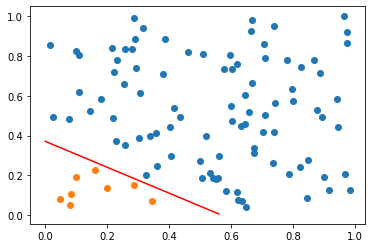

In [4]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(0, min(x1/m,1), 0.01)
plt.plot(xs, decision_bound(xs), 'r')

#### Generate random networks

In [5]:
# Parameters
num_nodes = 10
density = 5/(num_nodes-1) # limit average degree to 5
denser = 0.8
diode_thresh = 0.2 # on average each node has 1 diode
mask = np.random.uniform(0, 0.5, (num_nodes, num_nodes))
mask = mask + mask.T
con = mask < density
dense = mask < denser
diodes = mask < diode_thresh
node_cfg = np.random.permutation([1, 1, -1] + [0]*(num_nodes-3))

In [6]:
# Create the linear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask
tmp = np.random.rand(num_nodes, num_nodes)
lin_network = (tmp + tmp.T) * dense

In [7]:
# Create the nonlinear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask. Then, apply the diode mask by assigning random directions to each diode.
relu_network = (tmp + tmp.T) * (dense & ~(diodes | diodes.T))
diodes_dir = tmp < tmp.T
relu_network += diodes_dir * diodes

In [8]:
# Print network statistics:
diag_mask = ~np.eye(lin_network.shape[0]).astype(bool)
print(f'Linear network edges: {np.sum(diag_mask * lin_network > 0)//2}')
print(f'ReLu network edges: {np.sum(diag_mask * np.minimum(relu_network, relu_network.T) > 0)//2}')
print(f'ReLu network diodes: {np.sum(diag_mask * (relu_network != relu_network.T))//2}')

Linear network edges: 41
ReLu network edges: 36
ReLu network diodes: 5


#### Build Network in ~~PySpice~~ LTSpice

In [13]:
circuit = Circuit('Network')
nodes = np.char.add(np.full(num_nodes, 'n'), np.arange(num_nodes).astype(str))

In [14]:
net = LinearNetwork('linear', lin_network, node_cfg)

In [12]:
net.solve(train['x'][0])

AttributeError: 'int' object has no attribute 'shape'

In [15]:
l = net.read()

In [16]:
l

array([[0.52557236],
       [0.53779733],
       [0.5905766 ],
       [0.5095301 ],
       [0.5599315 ],
       [0.51948243],
       [0.53465784],
       [0.9990042 ],
       [0.5308634 ]], dtype=float32)

#### Solve with normal solver and PySpice

In [ ]:
inp1 = train['x'][0, None]

diy_solver = opt.inference(lin_network, inp1, node_cfg)
spice_solver = net.solve(inp1) or net.read()

In [ ]:
inp1

array([[0.50953014, 0.99900418]])

In [ ]:
print(lin_network)

[[0.04223934 0.89589543 1.24266344 0.82631479 0.83985805 1.12493371
  1.05584502 0.76450271 0.71821157 0.97663831]
 [0.89589543 1.94335897 1.05359196 1.31469167 0.74250531 1.02439593
  0.97116581 1.09423346 0.98516011 0.17031571]
 [1.24266344 1.05359196 0.17217815 1.1137688  0.23247437 0.83092974
  0.77905301 0.61608632 0.87844044 1.54911909]
 [0.82631479 1.31469167 1.1137688  0.         1.71361644 1.37373144
  0.57256847 1.02123503 0.36474293 1.00025176]
 [0.83985805 0.74250531 0.23247437 1.71361644 1.51844118 0.32740392
  0.66676301 1.79898663 0.96240378 1.02428949]
 [1.12493371 1.02439593 0.83092974 1.37373144 0.32740392 0.68230211
  1.23046427 0.         0.59007422 1.34171724]
 [1.05584502 0.97116581 0.77905301 0.57256847 0.66676301 1.23046427
  1.06439079 1.17959773 1.60189147 1.4405797 ]
 [0.76450271 1.09423346 0.61608632 1.02123503 1.79898663 0.
  1.17959773 1.08412303 0.68588588 1.60462902]
 [0.71821157 0.98516011 0.87844044 0.36474293 0.96240378 0.59007422
  1.60189147 0.68588

In [ ]:
diy_solver, spice_solver

(array([[0.44899336, 0.50294916, 0.42824706, 0.43407817, 0.50953014,
         0.42239947, 0.47492998, 0.42929077, 0.99900418, 0.        ]]),
 array([[0.52557236],
        [0.53779733],
        [0.5905766 ],
        [0.5095301 ],
        [0.5599315 ],
        [0.51948243],
        [0.53465784],
        [0.9990042 ],
        [0.5308634 ]], dtype=float32))